Comenzaremos revisando las versiones de Python y Tensorflow

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Posteriormente, definiremos algunos parámetros para personalizar nuestras gráficas de matplotlib.

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

Con relación a las imágenes, se creará un folder, así como una función de nombre save_fig() que nos permitirá guardas nuestro gráficos en nuestra carpeta.



In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Ahora, nos encargaremos de verificar que exista una GPU activa para poder correr el código de manera efectiva, en caso contrario, lanzará una advertencia para utilizar una.

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

Para comenzar a trabajar, instalaremos la librería Gymnasium, la cual nos porporciona varios ambientes para el aprendizaje por refuerzo. Además, se utilizarán algunas librerías extra que serán de utilidad en este ejercicio, como lo son CartPole, Box2D, Atari environments, etc.

In [6]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 10.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00


Una vez instalada la librería de gymnasium, procederemos a crear un ambiente CartPole

In [7]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

Este ambiente está compuesto de un carrito y un poste que se encuentra encima de él. El carrito se tiene que mover de izquierda a derecha con el fin de que el poste no se caiga. A continuación, se inicializará el ambiente a través del método ```reset()```, el cual regresa una observación y un diccionario que contiene más información sobre él.



In [8]:
obs, info = env.reset(seed=42)
obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [9]:
info

{}

Se observa que la observación consiste de un arreglo de 4 dígitos, los cuales, representan lo siguiente:

*   El primero representa la posición horizontal del carrito
*   El segundo representa su velocidad
*   El tercero corresponde al ángulo del poste (con 0 = vertical)
*   Y el cuarto es la velocidad angular del poste.

Podemos visualizar nuestro ambiente utilizando el método ```render()```.





In [10]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

A continuación se creará una función que nos permita renderizar y observar nuestro ambiente.

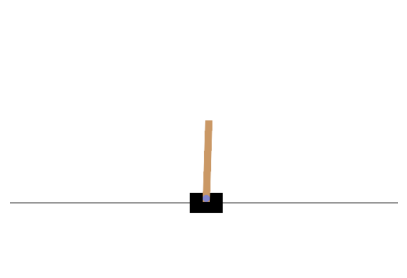

In [11]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Para interactuar con nuestro ambiente, el agente debe de seleccionar una acción del "espacio de acción", el cual, en este caso, se vería de la siguiente manera

In [12]:
env.action_space

Discrete(2)

Lo que nos dice esto, es que existen dos acciones que el agente puede realizar: moverse a la izquierd (0) o moverse a la derecha (1). En este caso, la observación arrojó que el poste está inclinado hacia la derecha (`obs[2] > 0`), de manera que el carrito se tendrá que mover hacia la derecha.

In [13]:
action = 1  # acelerar hacia la derecha
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Ahora, el coche se movió hacia la derecha (`obs[1] > 0`) y el poste se ecuentra todavía inclinado hacia la derecha (`obs[2] > 0`), no obstante, su velocidad angular es negativa (`obs[3] < 0`), de manera que, en el siguiente paso, posiblemente se inclinará hacia la izquierda. Nuestro ambiente ahora se ve de la siguiente manera.

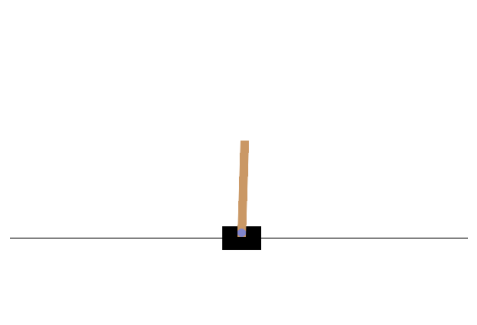

In [14]:
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

También podemos conocer la recompensa que recibió nuestro agente.

In [15]:
reward

1.0

Cuando el juego se termina, el ambiente regresa `done=True`, no obstante, en este momento, el juego todavía no está finalizado.

In [16]:
done

False

De igual manera, puede suceder que el juego termine temprano si es que se ha excedido cierto límite de tiempo o si un objeto ha excedido ciertas fronteras. En este caso, `truncated` será `True`.En este momento, nos damos cuenta de que el proceso no ha sido truncado.

In [17]:
truncated

False

La secuencia de pasos entre el momento en que se reinicia el entorno hasta que se completa o se trunca se llama "episodio". Al final de un episodio (es decir, cuando `step()` devuelve `done=True` o `truncated=True`), se debe de reiniciar el entorno antes de continuar usándolo.

In [18]:
if done or truncated:
    obs, info = env.reset()

Ahora, para garantizar que el poste no se caiga, necesitamos definir una "política" que nuestro agente utilizará como estrategia para seleccionar una acción en cada paso, además, debe de ser capaz de usar las acciones y observaciones pasadas para decidir qué hacer.

# A simple hard-coded policy

This policy is simple, if the pole tilts to the right, then the car should move to the right and vice versa.

In [19]:
# This function does what we described above.
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []

# Here, we are going to execute 500 episodes
for episode in range(500):
    # We are going to storage each episode's reward in this variable
    episode_rewards = 0
    # We will reset our environment into different states for each episode
    obs, info = env.reset(seed=episode)
    # Each episode will consist of 200 steps based on our basic policy
    for step in range(200):
        # We call our define function to take the next action
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    # We append the rewards of each episode to the totals array
    totals.append(episode_rewards)

Next, we can observe the mean reward that our agent got in each episode, in this case, on average, the agent kept the pole up for almost 42 steps. On the other hand, we can see that the best the agent did was to keep the pole up for 63 steps. Of course, what we want is to keep the pole up for 200 steps.

In [20]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Just for the sake of visualization, we can animate the process behind one episode as follows.

In [21]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

# Neural Network Policies

We can approach this problem using neural networks, where our input neurons will be the observations and our output neuron will be the probability to move to the left (action 0). However, to decide the next step, we will select randomly one of the two different states according to the stimated probabilities.

In [22]:
import tensorflow as tf

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Here, we created two layers of neurons, all of which are densely connected. The first one contains 5 neurons and the "relu" activation function, while the other layer only contains one neuron with a "sigmoid" activation function.

Previously, we stated that we are going to randomly choose one of the two states instead of choosing the one with the highest probability, and this is to let the agent to find a balance between exploring new solutions and exploting solutions that are known to work well.

Below, there is a function that will use the neural network to get the probability of moving left, and use it to run one episode.

In [23]:
def pg_policy(obs):
    # Obtaining the probability that the car will move to the left
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random  .rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

It may appear that the neural metwork didn't make much of a difference compared to the simple policy we created above. We must ensure that our neural network can learn, on its own, a better policy.

# Policy Gradients

To train our neural network, we need to define the target probabilities, this is, if the agent makes a good action, then we should increase its probability, and conversely, if it makes a bad action, we should reduce its probability. However, there is a problem, if we lose or win reward points in one episode, we don't really know which actions contributed to this effect.

The policy gradient algorithm takes this problem and, after several episodes, it makes positive reward actions more likely than negative reward actions.

The next function simulates one step using this model, we will assume that every action is the right one and then we can compute its gradients as well as its loss. We will store this gradients and modify them later.

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    # Gradient tape keeps track of the gradients
    with tf.GradientTape() as tape:
        # Obtains the probability of moving to the left
        left_proba = model(obs[np.newaxis])
        # Comparing the probability with a random number from 0 to 1 using a
        # uniform distribution
        action = (tf.random.uniform([1, 1]) > left_proba)
        # We define a constant (1), cast the True or False into a float type
        # and substract this value to 1.
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        # calculating the mean loss between the prediction and the target
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    # Computing the gradient of the loss with respect to the trainable
    # variables
    grads = tape.gradient(loss, model.trainable_variables)
    # Computing the first step
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


If `left_proba` is high, then it is very likely that action will be false, then, in `y_target`, we cast the variable into a float32; if action is false, then y_target would be equal to 1 - 0 = 1, thus, we set the target to 1, which means that, with a probability of going to the left should have been 100 percent, that is, the action taken was correct.

Now that we created the `play_one_step()` function, we should create another function to play multiple episodes and that returns all rewards and gradients for each episode.

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    # Storing all the rewards and gradients from each episode
    all_rewards = []
    all_grads = []

    for episode in range(n_episodes):
        # We initialize the rewards and gradients of one step
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            # We play one step
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        # We append the rewards and gradients of one episode
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

To apply the gradient algorithm, we should look at the rewards and discount them and then normalize them.

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    # iterating backward through the array
    for step in range(len(rewards) - 2, -1, -1):
        # calculationg the discounted reward
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    # creating an array of discounted awards
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    # obtaining mean of discounted awards
    reward_mean = flat_rewards.mean()
    # obtaining the std of discounted awards
    reward_std = flat_rewards.std()
    # returning the normalized awards
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

The discount operation allows us to see which rewards are the most significant or important in the agent's decision-making process, this is, a larger weight implies that the corresponding reward has a greater impact on shaping the agent's behavior and learning its policy. As we can see, discounting rewards involves applying a discount factor to future rewards in order to give less weight to distant rewards compared to immediate ones.

On the other hand, normalizing data is useful since it  helps stabilize training by ensuring that rewards are consistent and comparable across different episodes, since it prevents large rewards from dominating the learning process.

Now, it is time to train our neural network, we are going to define 150 iterations and 10 episodes per each. We will also define a maximum number of steps of 200, with a discount factor of 0.95.

We will start by defining the same neural network we created above.

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [ ]:
# let's create the neural net and reset the environment, for reproducibility
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

To apply the gradient to the trainable variables of our model, we will use a Nadam optimizer with a learning rate of 0.01. Furthermore, as a loss function, a binary crossentropy function is going to be used.

In [ ]:
# Defining the optimizer to apply the gradient to the trainable variables
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
# Defining the loss function
loss_fn = tf.keras.losses.binary_crossentropy

Now, it is time to run the algorithm. In each iteration, we are going to play 10 episodes and adjust the reward parameters so that in the next iteration the agent performs better.

In [ ]:
for iteration in range(n_iterations):
    # Calling the play multiple episodes function
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    # Returning the discounted and normalized rewards
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    # Storing the gradients from the episodes
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    # applying the gradients to the trainable variables using
    # a nadam optimizer
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())


Iteration: 150/150, mean rewards: 144.4

In [ ]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

After the  150 iterations, our agent was capable of keeping the pole upright for an average of 145 steps, which is an evident increase in the performance, still, we haven't achieved our goal, which is to keep the polo without falling over for 200 steps. Finally, to improve our model, we will use a Q-learning policy.

# Q-Learning Policy

To exemplify the process of Q-learning Policy, we may introduce the example of a Markov Decision Process (MDP) and then we will find the optimal Q values for this process using Q-value iteration.  The MDP can be seen below, where transition probabilities, rewards and possible actions are provided.




In [24]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-Value Iteration

To begin with the Q-Learning process, we have to initialize some default Q-Values, to do so, we are going to create a 3 $\times$ 3 matrix and we are going to fill it with infinite values.

Since we have the whole MDP, we can iterate until we obtain the optimal Q-values for this process, and, as we will see later, this method provides an exact solution to finding the best Q-values.

In [25]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [26]:
gamma = 0.90  # the discount factor


history1 = [] # extra code: needed for the figure below
# Here, we append the Q-values corresponding to the transition probabilities
# rewards and possible actions.
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code

# Q-learning

In Q-learning, on the other hand, we obtain Q-values through the interaction of our agent with the environment. Similar to the previous case, we will need to define a set of predetermined Q-values which will gradually improve based on said interactions. Once the optimized Q-Values are obtained, our agent will then have to choose actions that have the highest Q-values.

We start by simulating the agent moving around the environment, so we will define a new function to get to a new state as well as a reward

In [27]:
def step(state, action):
    # Obtaining the probability of the given state and action
    probas = transition_probabilities[state][action]
    # Selecting the next action given the probabilities
    next_state = np.random.choice([0, 1, 2], p=probas)
    # Obtaining the reward of the next action
    reward = rewards[state][action][next_state]
    return next_state, reward

We will also need an exploration policy which allow us the agent to explore every single state.

In [28]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

To run the Q-learning algorithm, we execute the following block of code.

In [29]:
# initializes the Q-Values
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [30]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    # We obtain the next action given by the exploration policy.
    action = exploration_policy(state)
    # Obtaining the next state given by the action and current state
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    # Computing the new Q-values
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

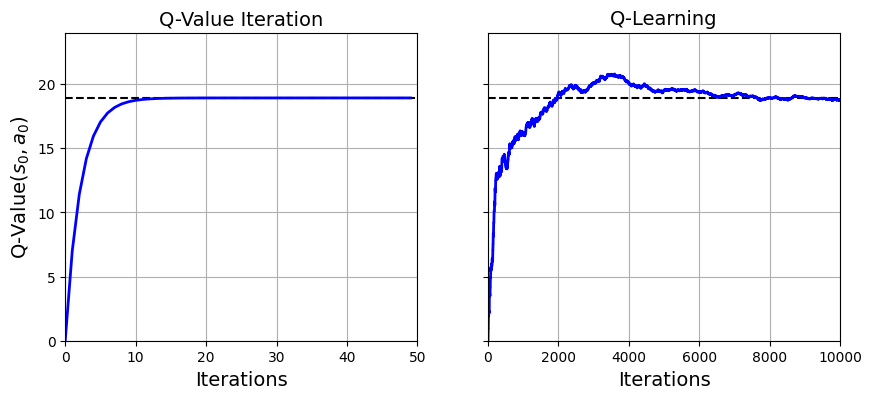

In [31]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

# save_fig("q_value_plot")
plt.show()

Since we don't have a well defined Markov Process to obtain the Q-values in the learning process, the convergence to the optimal values requires much more iterations than with the Q-Iteration. Once we obtained some useful Q-values to work with, we will start the agent learning process so that it acts based on the best Q-values for each action.

# Deep Q-Network

Now, we may combine the Q-learning technique with deep learning to train our agent and find an optimal Q-function, which will estimate the sum of dicounted rewards when taking an action before it sees its outcome. We are going to start by defining our neural network, it will take as the input, the four observations from the environment, and it will output 2 results. Our neural network is a densely connected layer with 1 hidden layer consisting of 32 neurons, both the input and hidden layer use a `elu` activation function. All of this can be seen below

In [32]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

input_shape = [4]  # == env.observation_space.shape
n_outputs = 2  # == env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

To select an action, we will pick the action with the largest Q-value, however, to ensure that the agent expores other options, we may choose a random action with probability `epsilon`.

In [33]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()  # optimal action according to the DQN

Next, to store the agent's past experiencies, we will make use of a structure known as a replay buffer, which is just a generalization of a queue and a stack. For this case, our buffer will have a maximum length of 2000 elements.


In [34]:
from collections import deque

replay_buffer = deque(maxlen=2000)

We can sample the experiences introduced into the replay buffer, it will return a 6 NumPy arrays: `[states, actions, rewards,next_states, dones, truncateds]`. This samples are randomly chosen from the replay buffer to train the agent.

In [35]:
def sample_experiences(batch_size):
    # choosing n random numbers from 0 to len(replay buffer)
    # where n is the batch_size
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    # creating a list of random experiences
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

Lets play one step and record its experience in the replay buffer.

In [36]:
def play_one_step(env, state, epsilon):
    # We choose one action given by the greedy policy
    action = epsilon_greedy_policy(state, epsilon)
    # taking the next step and recording the experience
    next_state, reward, done, truncated, info = env.step(action)
    # appending the experience
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

Next, a function to sample one experience from the replay buffer is created, in order to perform a training step.

In [37]:
# extra code – for reproducibility, and to generate the next figure
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

In [38]:
# Our batch size will consist of 32 random samples of experiences
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):
    # sampling random experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    # Obtaining the q values of the possible next states
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    # computing the targer Q values
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    # one hot encoding the actions to associate them to the q values
    mask = tf.one_hot(actions, n_outputs)
    # keepting track of the gradients
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    # computing the gradients with respect to each trainable variable
    grads = tape.gradient(loss, model.trainable_variables)
    # applying the gradients to minimize loss
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

And finally, we will train the model. As we can observe, we will run 600 episodes consisting of 200 steps.

In [39]:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights

Episode: 52, Steps: 20, eps: 0.898

Episode: 600, Steps: 200, eps: 0.010

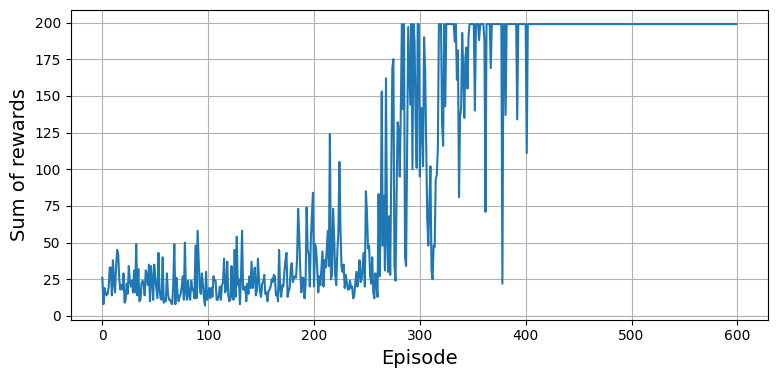

In [40]:
# extra code – this cell generates and saves Figure 18–10
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

In [41]:
show_one_episode(epsilon_greedy_policy)

As we can see, although extensive, this training method seems much better than the previous policies employed. We saw that with a simple hard-coded policy, the agent was not able to get close to the 200 steps to keep the pole upright, on the other hand, using one neural network without training was not a good idea either. However, with the Gradient policy, we saw a significative improvement, since we obtained an average reward of 145, which is not ideal, and it is actually lower than some values shown in other works, but it was a big step forward. Finally, as we can see using a Q-learning approach with deep learning, creates a robust agent capable of carrying out the task successfully.

In [ ]:
print("hello world")
print("hello world, again")
print("a huevito solo faltan 11 episodios")